* Tides impact in the river channel

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools,rivertools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import StraTimeSeries as sts
import DetermineEdgePlume as DEP
import R_mixStuff as RS
from R_mixStuff import sites
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2., rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [3]:
## load grid_T model results
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octnotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
maynotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc')
jannotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

In [4]:
## load grid_U model results to find peak ebbs at river mouth
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

In [5]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind,indices,ave=False):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']
        if ave == False:
            S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        else:
            S_ave = np.nanmean(S[indices[:]],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

(48.95, 49.35)

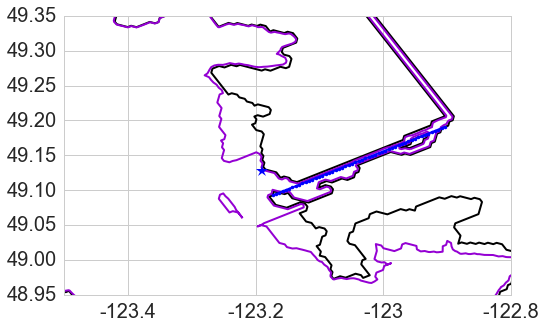

In [39]:
fig, ax = plt.subplots(1,1,figsize = (8,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = octall_T.variables['nav_lon']
lat = octall_T.variables['nav_lat']
ax.plot(lon[36,70:123],lat[36,70:123],'b.-')
#ax.plot(lon[36,94],lat[36,94],'g*')
#ax.plot(lon[36,70],lat[36,70],'y*')
#ax.plot(lon[36,80],lat[36,80],'y*')
ax.plot(lon[44,72],lat[44,72],'b*',markersize = 12) ## Steveston
#ax.plot(lon[36,102],lat[36,102],'c*')
#ax.plot(lon[38,72],lat[38,72],'r.') ## grid cell that peak ebb based on
#ax.plot(lon[466-380,329-240],lat[466-380,329-240],'y*')
ax.set_xlim([-123.5,-122.8])
ax.set_xticks([-123.4,-123.2,-123,-122.8])
ax.set_xticklabels([-123.4,-123.2,-123,-122.8])
ax.set_ylim([48.95,49.35])

* Oct

In [7]:
U = {}
for month,gridU in zip(['jan','oct','may'],[janall_U,octall_U,mayall_U]):
    U[month] = gridU.variables['vozocrtx']

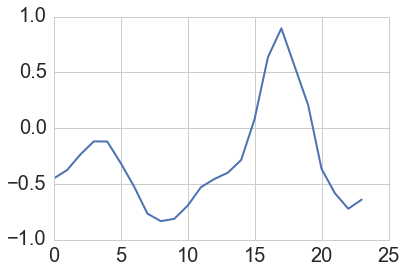

In [8]:
plt.plot(U['oct'][:24,0,38,72])


PFC = {} ## short form of peak ebb currents!
PFT = {}## short form of peak ebb times!
for month in ['jan','oct','may']:
    PFC[month] = [];
    PFT[month] = [];
    
for month in ['jan','oct','may']:
    for t in np.arange(0,len(U[month]),24):
        pfc = np.nanmax(U[month][t:t+24,0,38,72])
        PFC[month].append(pfc)
        pft = np.nanargmax(U[month][t:t+24,0,38,72])+t
        PFT[month].append(pft)

In [9]:
## IF BY USING SSH
SSH = {}
for month,gridT in zip(['jan','oct','may'],[janall_T,octall_T,mayall_T]):
    SSH[month] = gridT.variables['sossheig']

In [10]:
PFC_ssh = {} ## short form of peak ebb currents!
PFT_ssh = {}## short form of peak ebb times!
for month in ['jan','oct','may']:
    PFC_ssh[month] = [];
    PFT_ssh[month] = [];
    
for month in ['jan','oct','may']:
    for t in np.arange(0,len(SSH[month]),24):
        pfc = np.nanmax(SSH[month][t:t+24,38,72])
        PFC_ssh[month].append(pfc)
        pft = np.nanargmax(SSH[month][t:t+24,38,72])+t
        PFT_ssh[month].append(pft)

In [42]:
def salinity(axes_2,grid_T,string,dep_ind,indices,levels, ave = True):
    """Plot the salinity profile contourf and contour of 10 psu only"""
    S_small = {};

    S = grid_T.variables['vosaline']
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    
    Distances = np.zeros([123-70])
    for i in range(0,len(Distances)):
        Distances[i] = geo_tools.haversine(lon[36,70],lat[36,70],lon[36,i+70],lat[36,i+70]) 
    
    #levels = [4]
    if ave == True:
        S_small[string] = np.ma.masked_array(np.nanmean(S[indices[:],:,36,70:123],axis = 0),mask =np_mask[:,36,70:123])
        color = 'w'
        mesh = axes_2.contourf(lon[36,70:123],dep[:],S_small[string][:],np.arange(0,31,1),cmap='jet')
    elif ave ==False:
        S_small[string] = np.ma.masked_array(S[indices, :, 36, 70:123],mask = np_mask[:,36,70:123])   
        color = 'cyan' 
    elif ave =='Median':
        S_small[string] = np.ma.masked_array(S[indices, :, 36, 70:123],mask = np_mask[:,36,70:123])
        color = 'w'
        mesh = axes_2.contourf(Distances[:],dep[:],S_small[string][:],np.arange(0,31,1),cmap='jet')
        #mesh = axes_2.contourf(lon[36,70:123],dep[:],S_small[string][:],np.arange(0,31,1),cmap='jet')
    #CS = axes_2.contour(lon[36,70:123],dep[:],S_small[string][:],levels = levels,colors=color,linewidths=(2.5))  
    CS = axes_2.contour(Distances[:],dep[:],S_small[string][:],levels = levels,colors=color,linewidths=(2.5)) 
    axes_2.set_ylim([dep[-25],dep[0]])
    axes_2.set_xlim([0,25])
    #axes_2.set_xlim([lon[36,70],lon[36,123]])
    axes_2.set_ylabel('Depth (m)')
    axes_2.set_xlabel('Distance (km)')
    #axes_2.set_xticks([-123.15,-123.05,-122.95])
    #axes_2.set_xticklabels([-123.15,-123.05,-122.95])
    if ave == True or ave =='Median':
        return axes_2, mesh, CS
    else:
        return axes_2, CS

In [12]:
##  Create dicts
OBS = {}
MOD_ALL = {}
MOD_TIDES = {}
MOD_WINDS = {}
for mon in ['jan','oct','may']:
    OBS[mon] = []
    MOD_ALL[mon] = []
    MOD_TIDES[mon] = []
    MOD_WINDS[mon] = []

# Test the median distance

[-122.98997765391354,
 -122.97638704492184,
 -122.96556854248047,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359,
 -122.91359710693359]

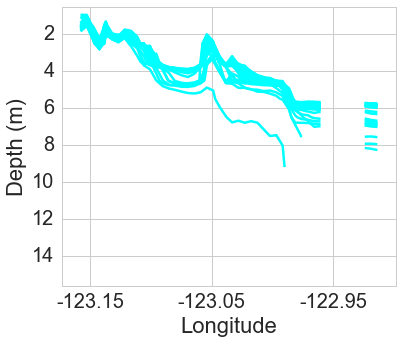

In [13]:
fig, axes_2 = plt.subplots(1,1,figsize = (6,5))
grid_T = jannotide_T
string1 = 'river+winds'
dep_ind = 10
#ind = 13
Pet ='jan'
levels = [10]
Ymaxs = []
for ind in np.arange(31):
    axes_2,CS = salinity(axes_2,grid_T,string1,dep_ind,PFT_ssh[Pet][ind],levels, ave = False)
    if len(CS.collections[0].get_paths()) == 2:
    #print(len(CS.collections[0].get_paths()))
        p = CS.collections[0].get_paths()[1]
    else:
        p = CS.collections[0].get_paths()[0]
    v = p.vertices
    y = v[:,0]
    x = v[:,1]
    Ymaxs.append( y[np.nanargmax(x)])
Ymaxs

In [14]:
Ymaxs = []
for i in np.arange(len(CS.collections[0].get_paths())):
    p = CS.collections[0].get_paths()[i]
    v = p.vertices
    y = v[:,0]
    x = v[:,1]
    Ymax = y[np.nanargmax(x)]
Ymaxs

[]

# Method 1. Plot all the peak flood times

In [16]:
ymax = {}
for string in [' river+winds',' river+tides',' river+winds+tides']:
    ymax[string] = {}
    for mon in ['jan','oct','may']:
        ymax[string][mon] = []

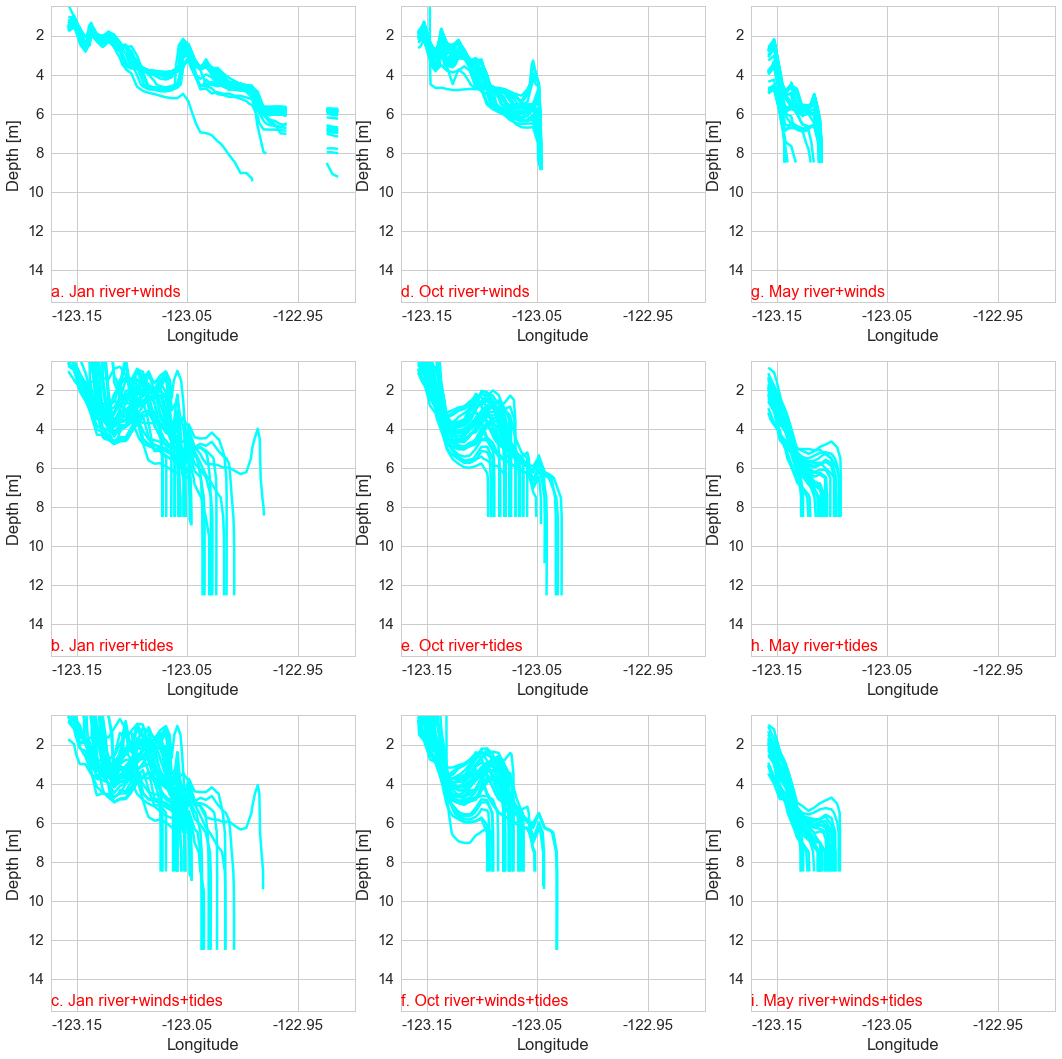

In [14]:
dep_ind = 10
listA = ['a.','d.','g.']
listB = ['b.','e.','h.']
listC = ['c.','f.','i.']
fig = plt.figure(figsize=(18, 18))
G = gridspec.GridSpec(3, 3) 
G.update(hspace=0.2, wspace=0.15)
for i, jan, octo, may,string1, Letter in zip(np.arange(3),[jannotide_T,jannowind_T,janall_T],\
                                     [octnotide_T,octnowind_T,octall_T],\
                                     [maynotide_T,maynowind_T,mayall_T],\
                                     [' river+winds',' river+tides',' river+winds+tides'],\
                                      [listA,listB,listC]):
    row = 0;
    for grid_T,string2, Pet, letter in zip([jan,octo,may], [' Jan',' Oct',' May'],['jan','oct','may'], Letter):
        axes_2 =fig.add_subplot(G[i,row]) ## rmix
        for ind in np.arange(31):
            axes_2,CS = salinity(axes_2,grid_T,string1,dep_ind,PFT[Pet][ind],levels, ave = False)
            if len(CS.collections[0].get_paths())>1:
                p = CS.collections[0].get_paths()[len(CS.collections[0].get_paths())-1]
            elif len(CS.collections[0].get_paths())==1:
                p = CS.collections[0].get_paths()[0]
            v = p.vertices
            y = v[:,0]
            x = v[:,1]
            ymax[string1][Pet].append(y[np.nanargmax(x)])

            
        axes_2.text(0,0.02, letter+string2+string1,transform = axes_2.transAxes,fontsize = 16, color = 'r')
        
        row = row+1

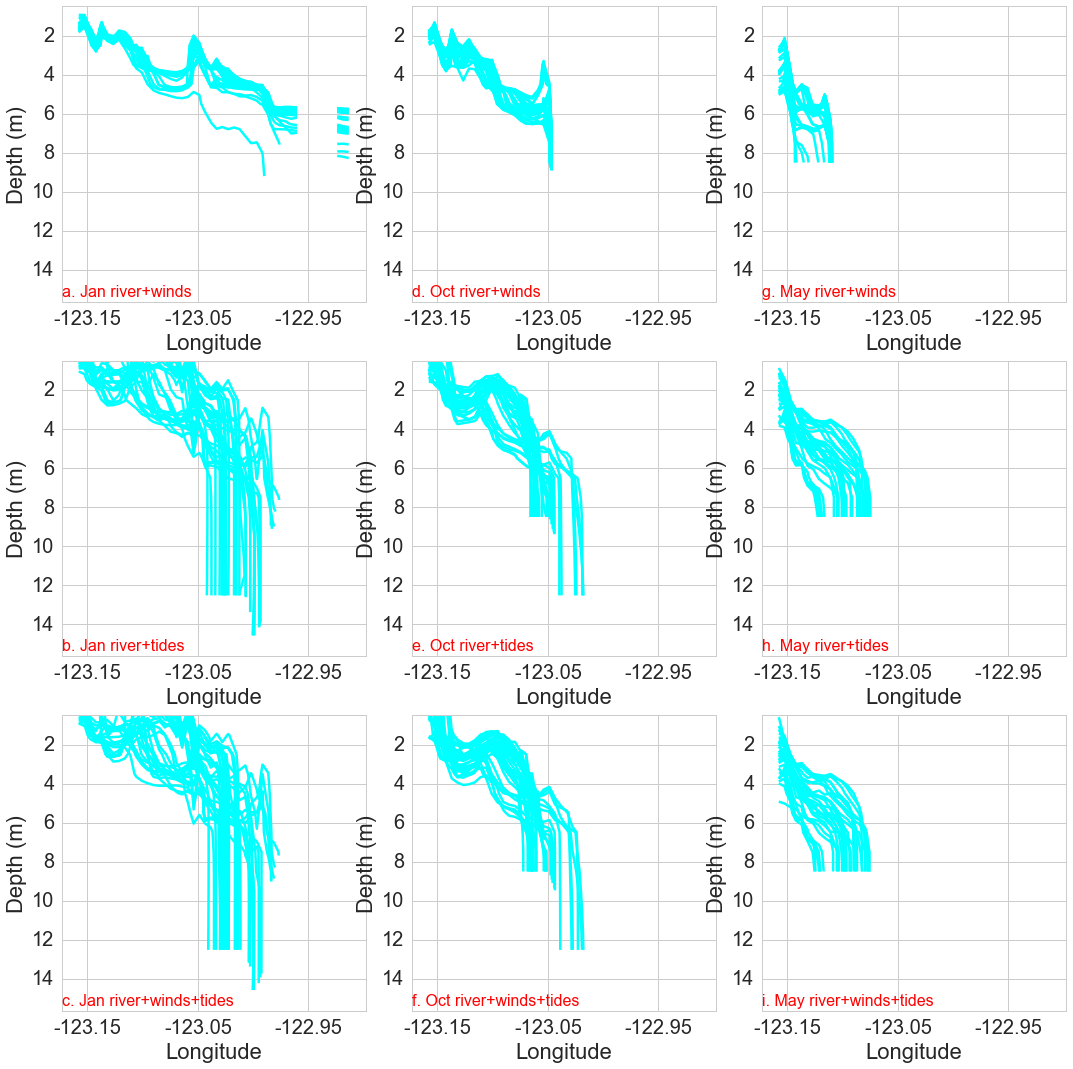

In [17]:
## IF BY SELECTING SSH AS THRESHOLD
dep_ind = 10
listA = ['a.','d.','g.']
listB = ['b.','e.','h.']
listC = ['c.','f.','i.']
levels = [10]
fig = plt.figure(figsize=(18, 18))
G = gridspec.GridSpec(3, 3) 
G.update(hspace=0.2, wspace=0.15)
for i, jan, octo, may,string1, MOD, Letter in zip(np.arange(3),[jannotide_T,jannowind_T,janall_T],\
                                     [octnotide_T,octnowind_T,octall_T],\
                                     [maynotide_T,maynowind_T,mayall_T],\
                                     [' river+winds',' river+tides',' river+winds+tides'],\
                                    [MOD_WINDS,MOD_TIDES,MOD_ALL],\
                                      [listA,listB,listC]):
    row = 0;
    for grid_T,string2, Pet, letter in zip([jan,octo,may], [' Jan',' Oct',' May'],['jan','oct','may'], Letter):
        axes_2 =fig.add_subplot(G[i,row]) ## rmix
        for ind in np.arange(31):
            axes_2,CS = salinity(axes_2,grid_T,string1,dep_ind,PFT_ssh[Pet][ind],levels, ave = False)
            if len(CS.collections[0].get_paths())>1:
                p = CS.collections[0].get_paths()[len(CS.collections[0].get_paths())-1]
            elif len(CS.collections[0].get_paths())==1:
                p = CS.collections[0].get_paths()[0]
            v = p.vertices
            y = v[:,0]
            x = v[:,1] 
            ymax[string1][Pet].append(y[np.nanargmax(x)])
  
            index = np.argmin(np.abs(lon[36,70:123] -y[np.nanargmax(x)])) +70 ## find the index of the closet grid
            #print(ind,string1,Pet,index,y[np.nanargmax(x)], lon[36,index] )
            d = geo_tools.haversine(lon[38,72],lat[38,72],lon[36,index],lat[36,index]) 
            MOD[Pet].append(d) 
        axes_2.text(0,0.02, letter+string2+string1,transform = axes_2.transAxes,fontsize = 16, color = 'r')
        
        row = row+1

In [18]:
for i in ['jan','oct','may']:
    for mod,string in zip([MOD_ALL,MOD_TIDES,MOD_WINDS],['all','tides','winds']):
        print(string, i, len(mod[i]))

all jan 31
tides jan 31
winds jan 31
all oct 31
tides oct 31
winds oct 31
all may 31
tides may 31
winds may 31


In [19]:
## These are the median distances that will be used in the next cell based on ssh
for string in [' river+winds',' river+tides',' river+winds+tides']:
    for mon in ['jan','oct','may']:
        a = np.where(ymax[string][mon] ==np.median(ymax[string][mon]))
        print(string,mon,np.where(ymax[string][mon] ==np.median(ymax[string][mon])),a[0][0],PFT_ssh[mon][a[0][0]])

 river+winds jan (array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),) 3 92
 river+winds oct (array([1]),) 1 44
 river+winds may (array([20]),) 20 484
 river+tides jan (array([14]),) 14 353
 river+tides oct (array([23]),) 23 552
 river+tides may (array([15]),) 15 371
 river+winds+tides jan (array([8]),) 8 206
 river+winds+tides oct (array([1]),) 1 44
 river+winds+tides may (array([19]),) 19 459


# Method 2. Plot median distance salinity one

In [15]:
geo_tools.haversine(X[424,312],Y[424,312],X[426,293],Y[426,293])

8.2765550636306351

 river+winds jan 80
 river+winds oct 43
 river+winds may 458
 river+tides jan 415
 river+tides oct 279
 river+tides may 22
 river+winds+tides jan 351
 river+winds+tides oct 738
 river+winds+tides may 532


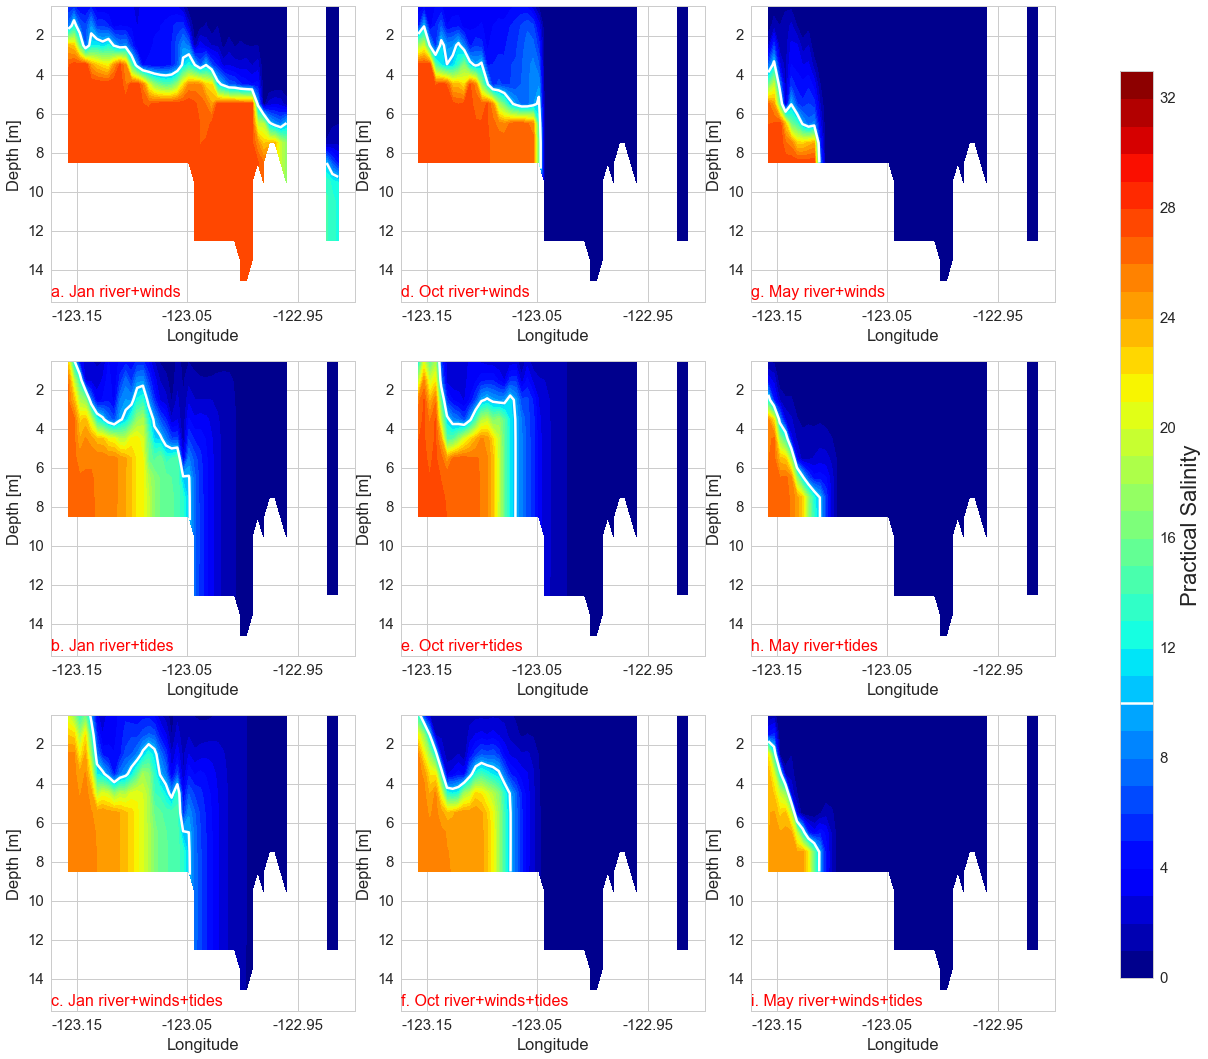

In [16]:
## median distance salinity case: to decrease the smearing 
## 10 salinity value contour
dep_ind = 10
listA = ['a.','d.','g.']
listB = ['b.','e.','h.']
listC = ['c.','f.','i.']
fig = plt.figure(figsize=(18, 18))
G = gridspec.GridSpec(3, 3) 
G.update(hspace=0.2, wspace=0.15)
for i, jan, octo, may,string1, Letter in zip(np.arange(3),[jannotide_T,jannowind_T,janall_T],\
                                     [octnotide_T,octnowind_T,octall_T],\
                                     [maynotide_T,maynowind_T,mayall_T],\
                                     [' river+winds',' river+tides',' river+winds+tides'],\
                                      [listA,listB,listC]):
    row = 0;
    for grid_T,string2, Pet, letter in zip([jan,octo,may], [' Jan',' Oct',' May'],['jan','oct','may'], Letter):
        axes_2 =fig.add_subplot(G[i,row]) ## rmix
        median_index = np.where(ymax[string1][Pet] ==np.median(ymax[string1][Pet]))  
        print(string1,Pet,PFT[Pet][median_index[0][0]])
        axes_2,mesh,CS = salinity(axes_2,grid_T,string1,dep_ind,PFT[Pet][median_index[0][0]],ave = 'Median')
        axes_2.text(0,0.02, letter+string2+string1,transform = axes_2.transAxes,fontsize = 16, color = 'r')
        row = row+1
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.add_lines(CS)
cbar.set_label('Practical Salinity',fontsize = 22)

 \blacksquare  aa

* aa

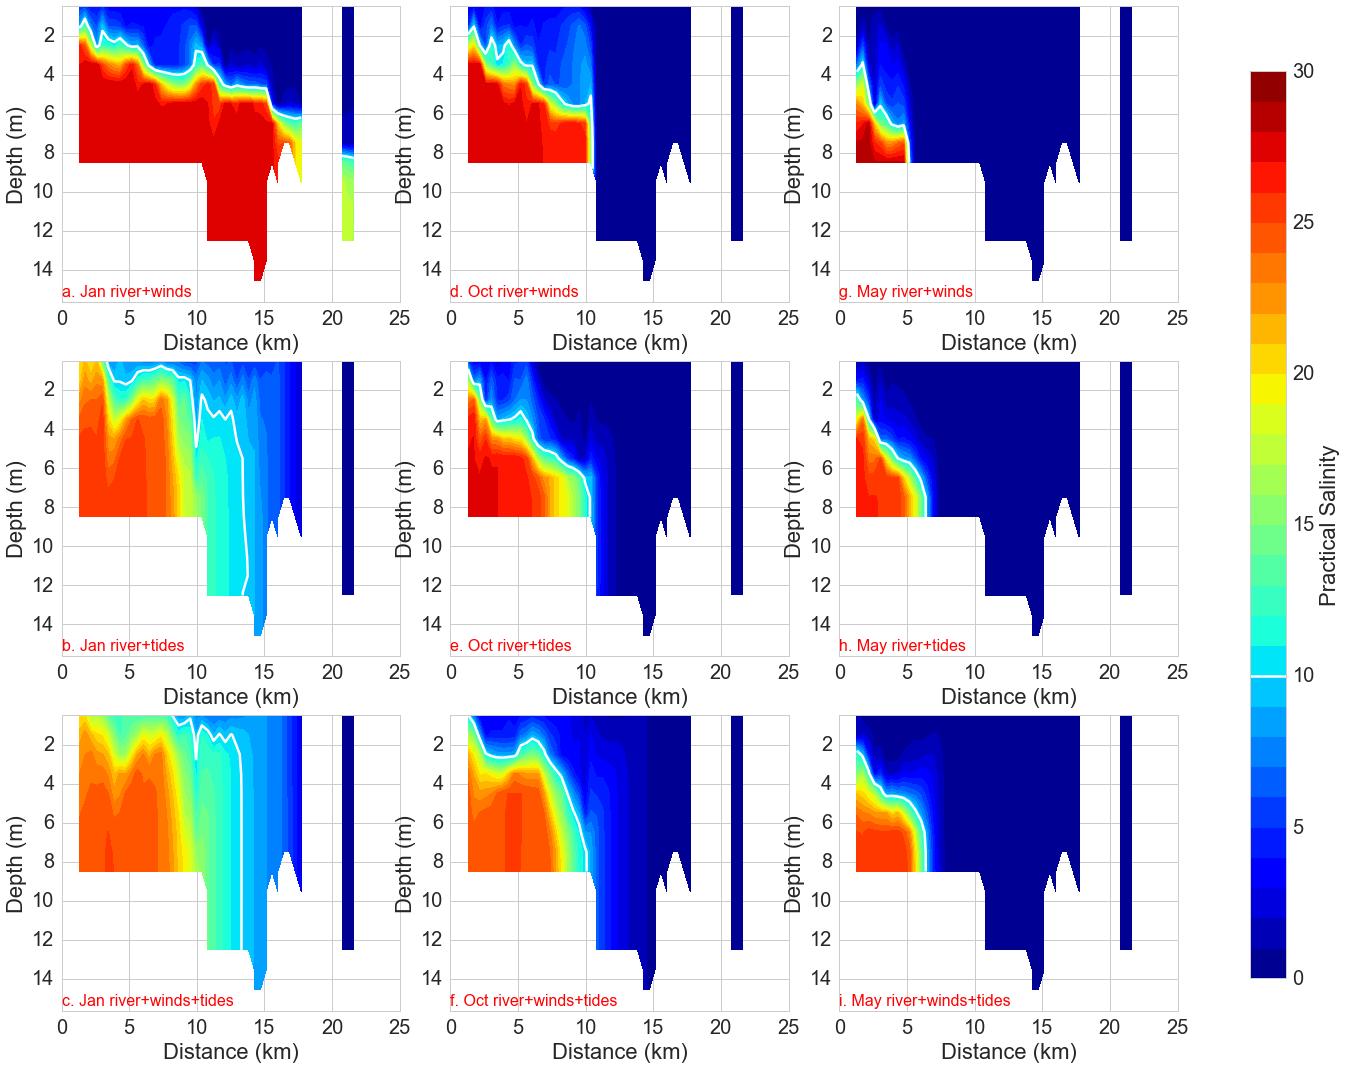

In [47]:
## USE SSH 
## 10 salinity value contour
dep_ind = 10
listA = ['a.','d.','g.']
listB = ['b.','e.','h.']
listC = ['c.','f.','i.']
fig = plt.figure(figsize=(20, 18))
G = gridspec.GridSpec(3, 3) 
G.update(hspace=0.2, wspace=0.15)
for i, jan, octo, may,string1, Letter in zip(np.arange(3),[jannotide_T,jannowind_T,janall_T],\
                                     [octnotide_T,octnowind_T,octall_T],\
                                     [maynotide_T,maynowind_T,mayall_T],\
                                     [' river+winds',' river+tides',' river+winds+tides'],\
                                      [listA,listB,listC]):
    row = 0;
    for grid_T,string2, Pet, letter in zip([jan,octo,may], [' Jan',' Oct',' May'],['jan','oct','may'], Letter):
        axes_2 =fig.add_subplot(G[i,row]) ## rmix
        median_index = np.where(ymax[string1][Pet] ==np.median(ymax[string1][Pet]))  
        #print(string1,Pet,PFT_ssh[Pet][median_index[0][0]])
        axes_2,mesh,CS = salinity(axes_2,grid_T,string1,dep_ind,PFT_ssh[Pet][median_index[0][0]],levels,ave = 'Median')            
        #print(CS.collections[0].get_paths())
        axes_2.text(0,0.02, letter+string2+string1,transform = axes_2.transAxes,fontsize = 16, color = 'r')
        row = row+1
fig.subplots_adjust(right=0.9)
#v = np.linspace(0, 5, 30, endpoint=True)
v = np.arange(0,31,5)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax,ticks = v)
#cbar.set_clim([0,30])
cbar.add_lines(CS)
cbar.set_label('Practical Salinity',fontsize = 22)

In [21]:
def Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH = 10):
    RUNOFFS = np.zeros(31)
    string = 1
    for t in np.arange(1,32): ## default tst -0, from start
        if string <10:
            real = nc.Dataset(data_path+str(data_start)+str(string)+'.nc')
            #print(data_path+str(data_start)+str(string),t)
        elif string >=10:
            real = nc.Dataset(data_path+str(string)+'.nc')
            #print(data_path+str(string),t)
        RUNOFFS[t-1] = real.variables['rorunoff'][0,500,395]*e1t[0,500,395]*e2t[0,500,395]/1000     
        string = string +1
    return RUNOFFS

In [22]:
e1t,e2t = rivertools.get_bathy_cell_size(grid='/ocean/jieliu/research/meopar/nemo-forcing/grid/'
         'coordinates_seagrid_SalishSea.nc')

In [23]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d'
data_start = 0
RUNOFFS = Get_River_Discharge(data_path,data_start,e1t,e2t,MONTH =10)

In [24]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2015m05d'
data_start = 0
RUNOFFS_may = Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH =5)

In [25]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2016m01d'
data_start = 0
RUNOFFS_jan = Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH= 1)

In [26]:
## HIGH TIDE BY ONLY USING THE HIGH TIDE DATA
for runoff, mon in zip([RUNOFFS_jan,RUNOFFS,RUNOFFS_may],['jan','oct','may']):
    for j in np.arange(31):
        value = 82419 - 9835*np.log(runoff[j])+ 22458 *np.log10(PFC_ssh[mon][j]+3.09)
        value = value/1000 - 8.3
        OBS[mon].append(value)

In [27]:
##  Create dicts
OBS_BOTH = {}
for mon in ['jan','oct','may']:
    OBS_BOTH[mon] = []
for runoff, mon in zip([RUNOFFS_jan,RUNOFFS,RUNOFFS_may],['jan','oct','may']):
    for j in np.arange(31):
        value = 78591 - 8320*np.log(runoff[j])+ 21279 *np.log10(PFC_ssh[mon][j]+3.09)
        value = value/1000 - 8.3
        OBS_BOTH[mon].append(value)

In [28]:
T = {}
for mon_string, year,mon in zip(['jan','oct','may'],[2016,2014,2015],\
                               [1,10,5]):
    T[mon_string] = [datetime.datetime(year,mon,day) for day in np.arange(1,32)]

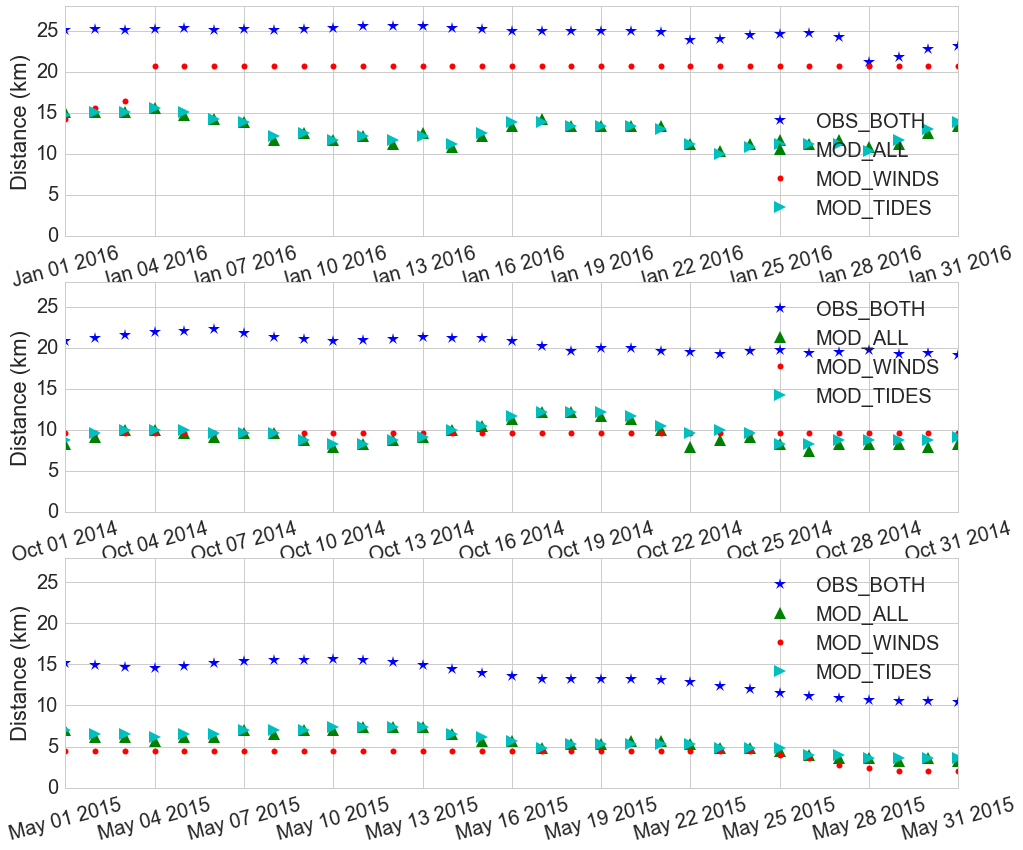

In [29]:
## USE BOTH HIGH AND LOW TIDE DATA TO PREDICT
fig, axs = plt.subplots(3,1,figsize = (16,14))
size = 12
for ax, mon in zip(axs, ['jan','oct','may']):
    ax.plot(T[mon],OBS_BOTH[mon],'b*',label = 'OBS_BOTH',markersize = size)
    ax.plot(T[mon],MOD_ALL[mon],'g^',label = 'MOD_ALL',markersize = size)
    ax.plot(T[mon],MOD_WINDS[mon],'r.',label = 'MOD_WINDS',markersize = size)
    ax.plot(T[mon],MOD_TIDES[mon], 'c>',label = 'MOD_TIDES',markersize = size)
    ax.legend(loc = 'best')
    ax.set_ylim([0,28])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15 )
    ax.set_ylabel('Distance (km)')
plt.show()

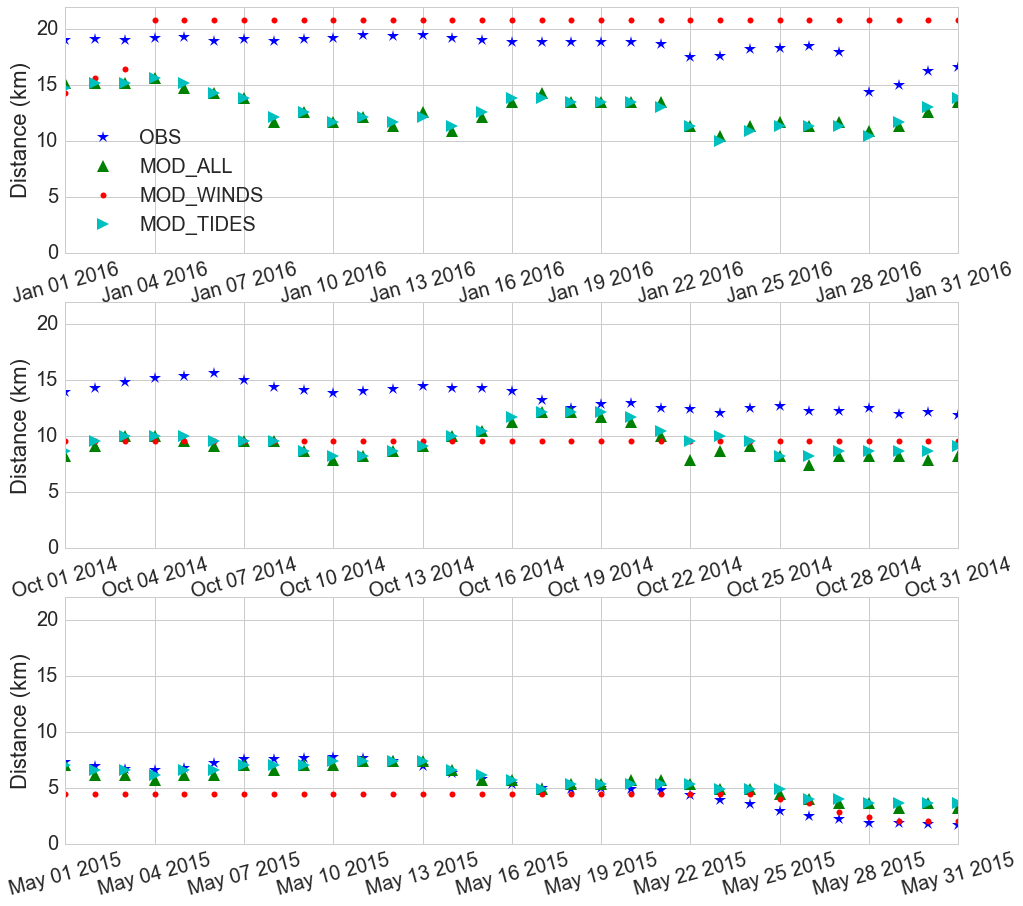

In [32]:
## ONLY HIGH TIDE DATA TO PREDICT
fig, axs = plt.subplots(3,1,figsize = (16,15))
size = 12
for ax, mon in zip(axs, ['jan','oct','may']):
    ax.plot(T[mon],OBS[mon],'b*',label = 'OBS',markersize = size)
    ax.plot(T[mon],MOD_ALL[mon],'g^',label = 'MOD_ALL',markersize = size)
    ax.plot(T[mon],MOD_WINDS[mon],'r.',label = 'MOD_WINDS',markersize = size)
    ax.plot(T[mon],MOD_TIDES[mon], 'c>',label = 'MOD_TIDES',markersize = size)
    if ax == axs[0]:
        ax.legend(loc = 'best')
    ax.set_ylim([0,22])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15 )
    ax.set_ylabel('Distance (km)')
plt.show()

# Method 3. Plot mean salinity one

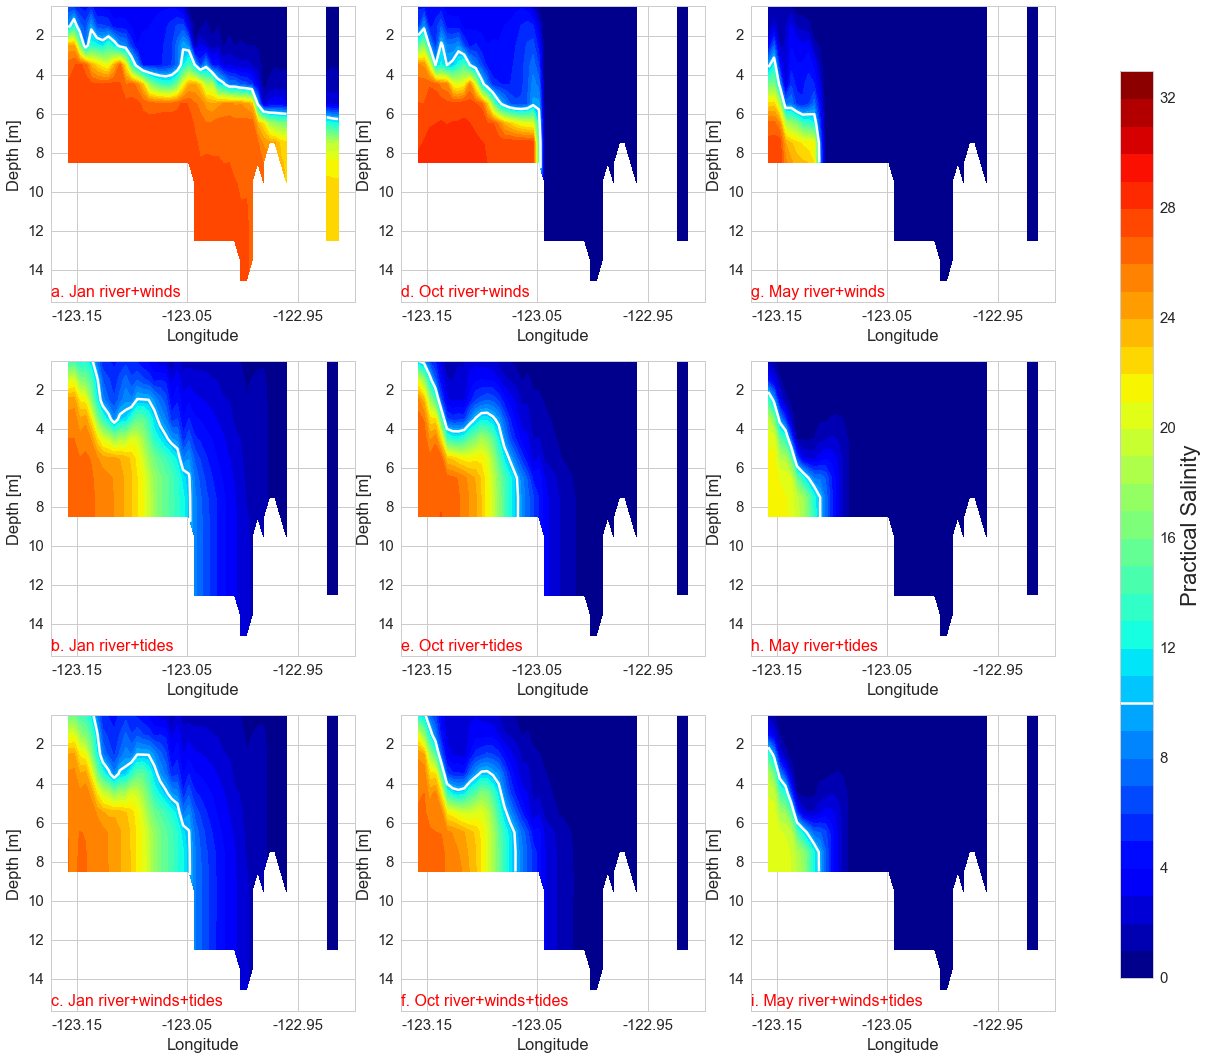

In [17]:
## mean salinity case
dep_ind = 10
listA = ['a.','d.','g.']
listB = ['b.','e.','h.']
listC = ['c.','f.','i.']
fig = plt.figure(figsize=(18, 18))
G = gridspec.GridSpec(3, 3) 
G.update(hspace=0.2, wspace=0.15)
for i, jan, octo, may,string1, Letter in zip(np.arange(3),[jannotide_T,jannowind_T,janall_T],\
                                     [octnotide_T,octnowind_T,octall_T],\
                                     [maynotide_T,maynowind_T,mayall_T],\
                                     [' river+winds',' river+tides',' river+winds+tides'],\
                                      [listA,listB,listC]):
    row = 0;
    for grid_T,string2, Pet, letter in zip([jan,octo,may], [' Jan',' Oct',' May'],['jan','oct','may'], Letter):
        axes_2 =fig.add_subplot(G[i,row]) ## rmix
        axes_2,mesh,CS = salinity(axes_2,grid_T,string1,dep_ind,PFT[Pet],levels)
        axes_2.text(0,0.02, letter+string2+string1,transform = axes_2.transAxes,fontsize = 16, color = 'r')
        row = row+1
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.add_lines(CS)
cbar.set_label('Practical Salinity',fontsize = 22)

In [9]:
import numpy as np
## high tide
82419 - 9835*np.log(8e3)+ 22458 *np.log10(5)

9727.3876261678088

In [10]:
78591 - 8320*np.log(8e3)+ 21279 *np.log10(1.9)

9749.1203267676265

In [20]:
78591 - 8320*np.log(7e2)+ 21279 *np.log10(5)

38959.394334705023

In [13]:
from salishsea_tools import geo_tools

In [17]:
geo_tools.haversine(X[426,293],Y[426,293],X[424,312],Y[424,312])

8.2765550636306351